<a href="https://colab.research.google.com/github/Diego-CB/DS-Proyecto/blob/main/modelo/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo
### Predicción de argumentos efectivos
    
Grupo:
- Cristian Aguirre: 20231
- Diego Córdova: 20212
- Marco Jurado: 20308
- Paola Contreras: 20213
- Paola de León: 20361

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

## Carga de Datos de Entreno

In [2]:
id = '1kzPayZj888s0RkHlxYHGXzHwdb63fEYH'
url = 'https://drive.google.com/uc?id=' + id
data = pd.read_csv(url)
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


## Liempieza de dataset de entreno

Se eliminaran las columnas de ***discourse_id*** y ***essay_id*** debido a que estas son solo identificadores no relevantes para el modelo. AL contrario, podrian causar ruido que genere malas predicciones.

Ademas se agrega una columna ***index*** y se guarda la columna ***discourse_text*** en una variable aparte ya que esta servira como entrada de la capa de word embedding.

Vamos a normalizar los datos para no generar ningun tipo de tendencia en el modelo pues como se ha visto en el analisis de datos los datos no estan nivelados y tenemos muchos más registros de un tipo de que de otro.

In [3]:
min_count = data['discourse_effectiveness'].value_counts().min()

# Filtrar las categorías 'adequate' y 'effective' para igualar el tamaño de 'ineffective'.
adequate_data = data[data['discourse_effectiveness'] == 'Adequate']
effective_data = data[data['discourse_effectiveness'] == 'Effective']

# Si hay más elementos que la cantidad mínima, eliminar los extras
if len(adequate_data) > min_count:
    adequate_data = adequate_data.sample(min_count, replace=False)

if len(effective_data) > min_count:
    effective_data = effective_data.sample(min_count, replace=False)

# Concatenar los DataFrames filtrados
data = pd.concat([adequate_data, effective_data, data[data['discourse_effectiveness'] == 'Ineffective']])

data.reset_index(drop=True, inplace=True)


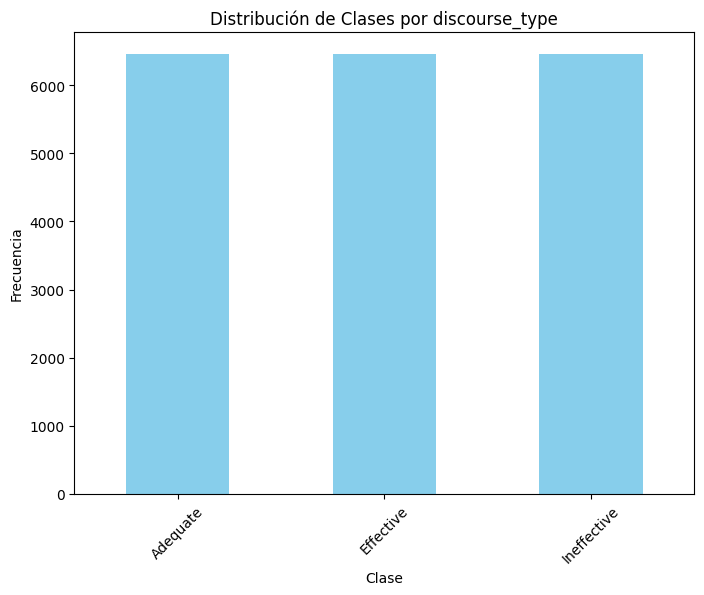

In [4]:
class_counts = data['discourse_effectiveness'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [5]:
data.drop('discourse_id', axis=1, inplace=True)
data.drop('essay_id', axis=1, inplace=True)
data['index'] = data.index
data.head()

,discourse_text,discourse_type,discourse_effectiveness,index
0,explaning first how Venus is often referred to...,Claim,Adequate,0
1,Some students agree they can benefit from bein...,Counterclaim,Adequate,1
2,i don't think its a bad way to test it i say t...,Position,Adequate,2
3,Our Forefathers created the Electoral College ...,Evidence,Adequate,3
4,It means we have a possibility to live in ther...,Claim,Adequate,4


Se agregara una variable para obtener el tamaño en palabras del texto como input

In [6]:
claim_sizes = [len(text) for text in data['discourse_text']]
data['claim_size'] = claim_sizes
data.head()

,discourse_text,discourse_type,discourse_effectiveness,index,claim_size
0,explaning first how Venus is often referred to...,Claim,Adequate,0,127
1,Some students agree they can benefit from bein...,Counterclaim,Adequate,1,202
2,i don't think its a bad way to test it i say t...,Position,Adequate,2,118
3,Our Forefathers created the Electoral College ...,Evidence,Adequate,3,239
4,It means we have a possibility to live in ther...,Claim,Adequate,4,182


In [7]:
texto_original = data['discourse_text']
data.drop('discourse_text', axis=1, inplace=True)
data.head()

,discourse_type,discourse_effectiveness,index,claim_size
0,Claim,Adequate,0,127
1,Counterclaim,Adequate,1,202
2,Position,Adequate,2,118
3,Evidence,Adequate,3,239
4,Claim,Adequate,4,182


### Encoding de variables categoricas
En este caso las variables ***discourse_effectiveness*** y ***discourse_type*** son categoricas.

In [8]:
type_map = {cat:index for index, cat in enumerate(data['discourse_type'].unique())}
print('> mapa para encoding de discourse_type', type_map)
data['discourse_type'] = [type_map[cat] for cat in data['discourse_type']]
data[['discourse_type']].head()

> mapa para encoding de discourse_type {'Claim': 0, 'Counterclaim': 1, 'Position': 2, 'Evidence': 3, 'Concluding Statement': 4, 'Lead': 5, 'Rebuttal': 6}


,discourse_type
0,0
1,1
2,2
3,3
4,0


In [9]:
type_map = {cat:index for index, cat in enumerate(data['discourse_effectiveness'].unique())}
print('> mapa para encoding de discourse_effectiveness', type_map)
data['discourse_effectiveness'] = [type_map[cat] for cat in data['discourse_effectiveness']]
data[['discourse_effectiveness']].head()

> mapa para encoding de discourse_effectiveness {'Adequate': 0, 'Effective': 1, 'Ineffective': 2}


,discourse_effectiveness
0,0
1,0
2,0
3,0
4,0


In [10]:
data.head()

,discourse_type,discourse_effectiveness,index,claim_size
0,0,0,0,127
1,1,0,1,202
2,2,0,2,118
3,3,0,3,239
4,0,0,4,182


## Generacion de Secuencias de Texto



Para la capa de incrustacion se usara para realizar ***word embedding*** de los argumentos dados como input.

In [11]:
texto_original

0        explaning first how Venus is often referred to...
1        Some students agree they can benefit from bein...
2        i don't think its a bad way to test it i say t...
3        Our Forefathers created the Electoral College ...
4        It means we have a possibility to live in ther...
                               ...                        
19381    Here are 2 of the reasons I think that the per...
19382    when are you take the video online you dont ha...
19383    Conclusion: you dont are prepared for take the...
19384    someone can use everything that many people sa...
19385    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 19386, dtype: object

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenizar las frases
tokenizador = Tokenizer()
tokenizador.fit_on_texts(texto_original)
secuencias = tokenizador.texts_to_sequences(texto_original)

# Rellenar (Pad) las secuencias para que tengan la misma longitud
secuencias = pad_sequences(np.array(secuencias))
# Dimensiones de entrada y salida de la capa de inscrustamiento

long_vocab = len(tokenizador.word_index) + 1
dim_incrustamiento = 2  # Representar cada palabra por un vector 2D

pd.DataFrame(secuencias).head()

<ipython-input-12-db5b52c38bd0>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  secuencias = pad_sequences(np.array(secuencias))


,0,1,2,3,4,5,6,7,8,9,...,836,837,838,839,840,841,842,843,844,845
0,0,0,0,0,0,0,0,0,0,0,...,669,144,2,153,7,1007,2,1136,4,703
1,0,0,0,0,0,0,0,0,0,0,...,10,22,286,1726,10,22,14,1137,2,9
2,0,0,0,0,0,0,0,0,0,0,...,304,110,69,9,765,110,40,9,22,32
3,0,0,0,0,0,0,0,0,0,0,...,36,47,8,887,29,1,269,14,2894,17
4,0,0,0,0,0,0,0,0,0,0,...,2,221,1,161,242,2,342,11,1,256


Ahora se exporta el tokenizador para usar con la app desarrollada

In [13]:
import joblib
joblib.dump(tokenizador, 'tokenizador.pkl')

['tokenizador.pkl']

## Split de Datos

In [14]:
y = data['discourse_effectiveness']
X = data.copy()
X.drop('discourse_effectiveness', axis=1, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,discourse_type,index,claim_size
4049,4,4049,263
15318,2,15318,165
16717,3,16717,360
12349,2,12349,91
2688,0,2688,25
...,...,...,...
11284,2,11284,62
11964,0,11964,82
5390,3,5390,322
860,3,860,447


Se usara la columna ***index*** que creamos anteriormente para dividir los datos de texto tokenizados

In [16]:
secuencias_train = [sec for index, sec in enumerate(secuencias) if index in X_train['index']]
secuencias_test = [sec for index, sec in enumerate(secuencias) if index in X_test['index']]

Ahora se borra la columna ***index*** en los datasdets "X" luego de usarla para hacer el split en las secuencias

In [17]:
X_train.drop('index', axis=1, inplace=True)
X_test.drop('index', axis=1, inplace=True)
X_train

,discourse_type,claim_size
4049,4,263
15318,2,165
16717,3,360
12349,2,91
2688,0,25
...,...,...
11284,2,62
11964,0,82
5390,3,322
860,3,447


Se pasan a arrays de numpy para darle como input al modelo

In [18]:
X_train = X_train.values
X_test = X_test.values
X_train

array([[  4, 263],
       [  2, 165],
       [  3, 360],
       ...,
       [  3, 322],
       [  3, 447],
       [  3, 211]])

Por ultimo, se convierten las secuencias a tensores para agregarlas como input al modelo y las variables objetivo ***y_test*** y ***y_train*** se convierten a arrays de numpy

In [19]:
import tensorflow as tf

secuencias_train_list = tf.stack(secuencias_train)
secuencias_test_list = tf.stack(secuencias_test)
y_train = y_train.values
y_test = y_test.values
secuencias_train_list

<tf.Tensor: shape=(15508, 846), dtype=int32, numpy=
array([[   0,    0,    0, ..., 1137,    2,    9],
       [   0,    0,    0, ...,    9,   22,   32],
       [   0,    0,    0, ...,   11,    1,  256],
       ...,
       [   0,    0,    0, ...,  423,    1,  170],
       [   0,    0,    0, ..., 1939,    4, 4755],
       [   0,    0,    0, ...,    2,  175,  131]], dtype=int32)>

## Modelo
Capas:
1. Embedding
2. LSTM
3. Dense

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, LSTM, Dropout, GRU

# Primer Pipeline: Procesamiento de texto
text_secuence_size = len(secuencias[0])

# Capa de Word Embedding
text_inputs = Input(
    shape=(text_secuence_size,)
)
text_pipeline = Embedding(
    input_dim=text_secuence_size,
    output_dim=4,
    input_length=len(secuencias),
)(text_inputs)

# Capas LSTM
text_pipeline = LSTM(
  text_secuence_size, dropout=0.3, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.01),
)(text_pipeline)
text_pipeline = Dropout(rate=0.3)(text_pipeline)

text_pipeline = LSTM(
  text_secuence_size, dropout=0.3, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.01),
)(text_pipeline)
text_pipeline = Dropout(rate=0.3)(text_pipeline)

text_pipeline = Flatten()(text_pipeline)

# Segundo Pipeline: Prediccion
predict_inputs = Input(shape=(2))
predict_pipeline = Dense(long_vocab, activation='softmax')(predict_inputs)

concat = tf.keras.layers.concatenate([text_pipeline, predict_pipeline])
dense = Dense(1, activation='softmax')(concat)

modelo = tf.keras.Model(inputs=[text_inputs, predict_inputs], outputs=dense)
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss ='categorical_focal_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision()],
    run_eagerly=True
)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 846)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 846, 4)               3384      ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 846, 846)             2879784   ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 846, 846)             0         ['lstm[0][0]']                
                                                                                              

In [21]:
print('Largo secuencias de entreno', len(secuencias_train))
print('Largo matriz de entreno:', len(X_train))
assert len(secuencias_train) == len(X_train)

Largo secuencias de entreno 15508
Largo matriz de entreno: 15508


## Entreno del Modelo

In [22]:
modelo.fit(
    [secuencias_train_list, X_train],
    y_train,
    batch_size = 64,
    epochs = 1,
    verbose = 'auto',
    validation_data = ([secuencias_test_list, X_test], y_test)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_focal_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(64, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


242/243 [============================>.] - ETA: 1s - loss: 538.6674 - accuracy: 0.3323 - precision: 0.6663

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_focal_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(20, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


243/243 [==============================] - ETA: 0s - loss: 538.6629 - accuracy: 0.3322 - precision: 0.6662

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_focal_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(38, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


243/243 [==============================] - 361s 1s/step - loss: 538.6629 - accuracy: 0.3322 - precision: 0.6662 - val_loss: 535.1597 - val_accuracy: 0.3378 - val_precision: 0.6684


In [23]:
[secuencias_train_list, X_train]

[<tf.Tensor: shape=(15508, 846), dtype=int32, numpy=
 array([[   0,    0,    0, ..., 1137,    2,    9],
        [   0,    0,    0, ...,    9,   22,   32],
        [   0,    0,    0, ...,   11,    1,  256],
        ...,
        [   0,    0,    0, ...,  423,    1,  170],
        [   0,    0,    0, ..., 1939,    4, 4755],
        [   0,    0,    0, ...,    2,  175,  131]], dtype=int32)>,
 array([[  4, 263],
        [  2, 165],
        [  3, 360],
        ...,
        [  3, 322],
        [  3, 447],
        [  3, 211]])]

## Exportar el modelo

In [24]:
modelo.save('nlp_model.h5')
joblib.dump(modelo, 'modelo.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['modelo.pkl']

In [25]:
import pickle

# Funciones para Deploy

Procesar claim de entrada (texto)

In [132]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def procesar_texto(claim:str, texto: str, tokenizador):
  ''' Necesita el Tokenizador creado arriba '''

  # Tokenizar las frase
  secuencia = tokenizador.texts_to_sequences(texto)
  secuencia = np.array(secuencia).T[0]

  # Rellenar (Pad) las secuencias para que tengan la misma longitud
  to_pad = np.array([[0 for _ in range(846)], secuencia.tolist()], dtype='object')
  secuencias = pad_sequences(to_pad)
  secuencia = secuencias[1]
  tensor_secuencias = tf.stack([secuencia])
  claim_size = len(texto)

  # Se hace el encoding del tipo de claiim
  claim_map = {'Lead': 0, 'Position': 1, 'Claim': 2, 'Evidence': 3, 'Counterclaim': 4, 'Rebuttal': 5, 'Concluding Statement': 6}

  if claim not in claim_map.keys():
    raise Exception(f'tipo de argumento \'{claim}\' no aceptado')

  # Preparar inputs para los 2 pipelines
  encoded_claim = claim_map[claim]
  X = np.array([[encoded_claim, claim_size]])

  # Juntar ambos pipeliins
  input = [tensor_secuencias, X]

  return input

Para pasarle como input al modelo debe estar como una matriz de la siguiente manera

[
  secuencias generadas,
  [
    tipo de claim,
    tamaño del claim
  ]
]

In [126]:
# Ejemplo

tokenizador = joblib.load('tokenizador.pkl')
joblib.dump(procesar_texto, 'funcion.pkl')

procesartexto = joblib.load('funcion.pkl')

texto_claim = 'asdasdasadasd'
tipo_claim = 'Counterclaim'

input = procesartexto(tipo_claim, texto_claim, tokenizador)

Ese array de input se le pasa al modelo para la prediccion

In [127]:
prediccion = modelo.predict([input])

1/1 [==============================] - 0s 111ms/step


Ahora se hace el "decode" del resultado de la prediccion

In [129]:
def decode_predict(predict):
  decode_map = ['Adequate', 'Effective', 'Ineffective']
  return decode_map[int(predict)]

In [131]:
prediccion_decoded = decode_predict(prediccion)
prediccion_decoded

'Effective'